## **Trabalho Final de Mineração de Dados - Visualização de Dados**
#### *Guilherme Moretti - 536179*

## **Questão de Pesquisa:**
### *Onde é o melhor local para instalar um datacenter em Nova York, considerando reclamações que possam afetar sua estabilidade?*

## **Motivação:**
A instalação de um datacenter requer uma infraestrutura confiável, livre de falhas frequentes de energia, enchentes, obras constantes e poluição ambiental que possam comprometer seu funcionamento. Com base no 311 Complaint Data, podemos identificar as regiões de Nova York com menor incidência de problemas nessas áreas, garantindo que o local escolhido ofereça segurança operacional, eficiência energética e estabilidade para os servidores.

Se evitarmos áreas com alta concentração de reclamações de problemas elétricos, falhas no sistema de esgoto/água, barulho e obras frequentes, além de condições ambientais ruins, poderemos sugerir as melhores regiões para um datacenter confiável e de baixo risco.

## **Público-alvo:**
Empresas de tecnologia e operadores de datacenters; Governo local e departamentos de infraestrutura; Investidores e imobiliárias comerciais

## **Contexto adicional:**
Em sala, foi recomendado que usássemos os dados dos últimos cinco anos, uma vez que o CSV original do 311 Service Requests era muito grande, com cerca de 21GB de informações. Através de uma pesquisa, encontramos um dataset que faz esse exato recorte, abrangendo os mesmos dados desde 2020 (a partir de 31/12/2019, de forma mais precisa) até o presente, com atualizações recorrentes. Portanto, optamos por utilizar o dataset que encontramos.

Está disponível em: *https://data.cityofnewyork.us/Social-Services/311-Service-Requests-2020/phws-rnrn/about_data*

In [1]:
%pip install pyarrow
%pip install pandas
import pandas as pd

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
data = pd.read_csv("dataset.csv", engine="pyarrow")

In [3]:
%pip install branca
import branca.colormap as cm
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from folium.plugins import HeatMap
from scipy.spatial import cKDTree
import numpy as np
from sklearn.cluster import KMeans

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
df_mod = data.copy()

In [5]:
rename = {
    'Unique Key': 'unique_key',
    'Created Date': 'created_date',
    'Closed Date': 'closed_date',
    'Complaint Type': 'complaint_type',
    'Descriptor': 'descriptor',
    'Location Type': 'location_type',
    'City': 'city',
    'Status': 'status',
    'Borough': 'borough',
    'Latitude': 'latitude',
    'Longitude': 'longitude',
}

df_mod = df_mod.rename(columns=rename)

In [6]:
df_mod = df_mod.dropna(subset=['borough'])
df_mod = df_mod[df_mod['borough'] != 'Unspecified']

## Criação das mascaras dos dataframes

Até o momento vamos trabalhar com 4 áreas:
1. Problemas Eletricos
2. Problemas com esgoto/Agua
3. Problemas de Ruido e Obras
4. Problemas de meio ambiente e condições insalubres

Esses quatro pontos foram escolhidos porque representam fatores críticos que podem afetar diretamente a operação e segurança de um datacenter.

#### 1. Problemas Elétricos ⚡

Um datacenter depende de fornecimento elétrico contínuo. Quedas de energia frequentes, oscilações de tensão ou infraestrutura elétrica deficiente podem causar interrupções, danos aos servidores e custos extras com geradores e baterias.

#### 2. Problemas com Esgoto/Água 💧

Vazamentos, enchentes e drenagem inadequada podem danificar equipamentos, comprometer a infraestrutura do prédio e aumentar os custos de manutenção. Além disso, a água pode afetar o sistema de refrigeração, essencial para manter os servidores operando em temperatura segura.

#### 3. Problemas de Ruído e Obras 🔨

Obras constantes podem gerar vibrações, prejudicando a estabilidade dos equipamentos e do prédio. Além disso, cortes na rede elétrica ou fibra óptica causados por escavações podem gerar falhas e períodos de inatividade, impactando o funcionamento do datacenter.


#### 4. Problemas de Meio Ambiente e Condições Insalubres 🌱
Poluição, infestação de pragas, calor excessivo e resíduos tóxicos podem impactar a eficiência do sistema de resfriamento, reduzir a vida útil dos equipamentos e até gerar restrições regulatórias para a instalação.
Analisando esses quatro fatores, podemos identificar locais mais seguros e estáveis, minimizando riscos operacionais e garantindo maior eficiência e confiabilidade para o datacenter. 🚀

#### Eletricos

In [7]:
mask_eletricos = (
    df_mod['complaint_type'].str.contains('elec', case=False, na=False) |
    df_mod['descriptor'].str.contains('power|lighting|wire|fuse', case=False, na=False)
)

#### Esgoto

In [8]:
mask_agua_esgoto = (
    df_mod['complaint_type'].str.contains('sewer|water leak|flooding|plumbing', case=False, na=False) |
    df_mod['descriptor'].str.contains('sewer|water leak|flooding|plumb', case=False, na=False)
)

#### Grandes obras / Ruidos

In [9]:
mask_obras_ruido = (
    df_mod['complaint_type'].str.contains('construction', case=False, na=False) |
    df_mod['descriptor'].str.contains('construction|noise', case=False, na=False)
)

#### Condições Insalubres e Riscos Ambientais

In [10]:
mask_insalubre = (
    df_mod['complaint_type'].str.contains('unsanitary', case=False, na=False) |
    df_mod['descriptor'].str.contains('unsanitary|dirty|rodent', case=False, na=False)
)

## Quais são os bairros com maiores quantidades de ocorrência?
Entender quais bairros têm mais ocorrências ajuda a identificar riscos estruturais e ambientais que podem impactar a operação do datacenter, como falhas elétricas, alagamentos, ruído excessivo e poluição. Isso permite escolher uma localização mais segura e estável, reduzindo custos e garantindo maior confiabilidade.

#### Total 

In [11]:
ocu_borough_total = df_mod[['complaint_type', 'descriptor', 'borough', 'status']]
ocu_borough_total_counts = ocu_borough_total.groupby('borough').size().reset_index(name='count').sort_values(by='count', ascending=True)

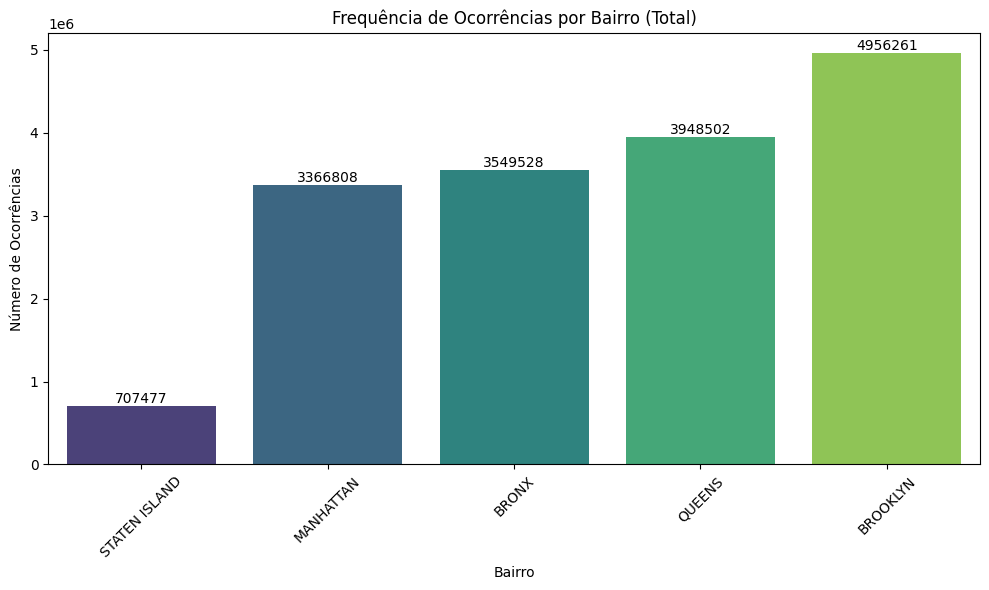

In [12]:
ocu_borough_total_counts.columns = ['borough', 'count']

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='borough', y='count', data=ocu_borough_total_counts, hue='borough', palette='viridis', dodge=False)
plt.title('Frequência de Ocorrências por Bairro (Total)')
plt.xlabel('Bairro')
plt.ylabel('Número de Ocorrências')
plt.xticks(rotation=45)

# Adicionar os valores dentro das barras
for patch in ax.patches:
    x = patch.get_x() + patch.get_width() / 2.0
    y = patch.get_height() + 0.5  # Ajuste para evitar sobreposição
    ax.text(x, y, int(patch.get_height()), ha='center', va='bottom', color='black', fontsize=10)

plt.tight_layout()
plt.show()


#### Ocorrências eletricas

In [13]:
# Colunas que vou usar para a analise
ocu_borough_ele = df_mod[mask_eletricos][['complaint_type', 'descriptor', 'borough', 'status']]
ocu_borough_ele_counts = ocu_borough_ele.groupby('borough').size().reset_index(name='count').sort_values(by='count', ascending=True)

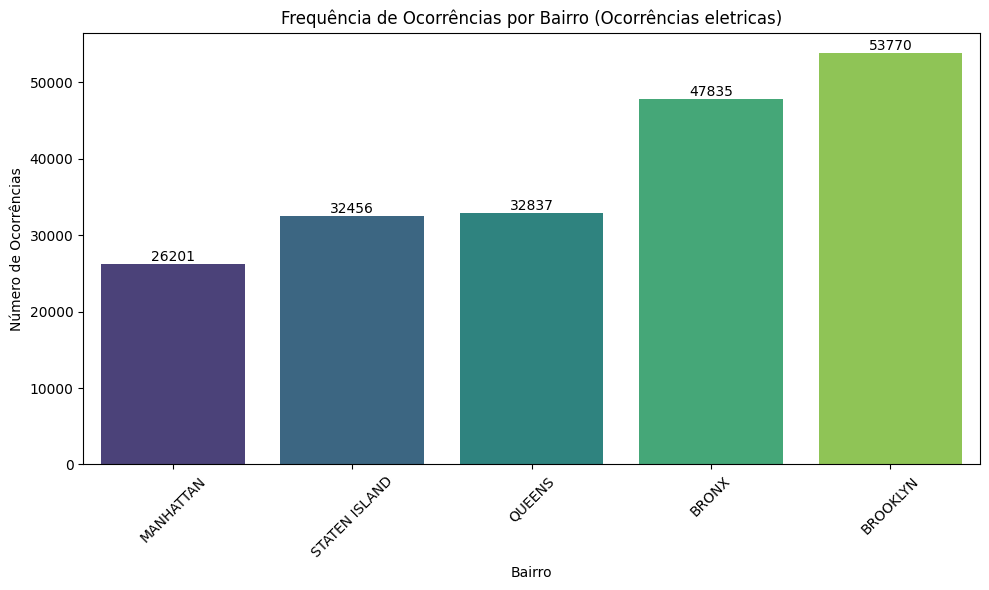

In [14]:
ocu_borough_ele_counts.columns = ['borough', 'count']

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='borough', y='count', data=ocu_borough_ele_counts, hue='borough', palette='viridis', dodge=False)
plt.title('Frequência de Ocorrências por Bairro (Ocorrências eletricas)')
plt.xlabel('Bairro')
plt.ylabel('Número de Ocorrências')
plt.xticks(rotation=45)

# Adicionar os valores dentro das barras
for patch in ax.patches:
    x = patch.get_x() + patch.get_width() / 2.0
    y = patch.get_height() + 0.5  # Ajuste para evitar sobreposição
    ax.text(x, y, int(patch.get_height()), ha='center', va='bottom', color='black', fontsize=10)

plt.tight_layout()
plt.show()


#### Ocorrência de Agua/Esgoto

In [15]:
ocu_borough_agua_esgoto = df_mod[mask_agua_esgoto][['complaint_type', 'descriptor', 'borough']]
ocu_borough_agua_esgoto_counts = ocu_borough_agua_esgoto.groupby('borough').size().reset_index(name='count').sort_values(by='count', ascending=True)

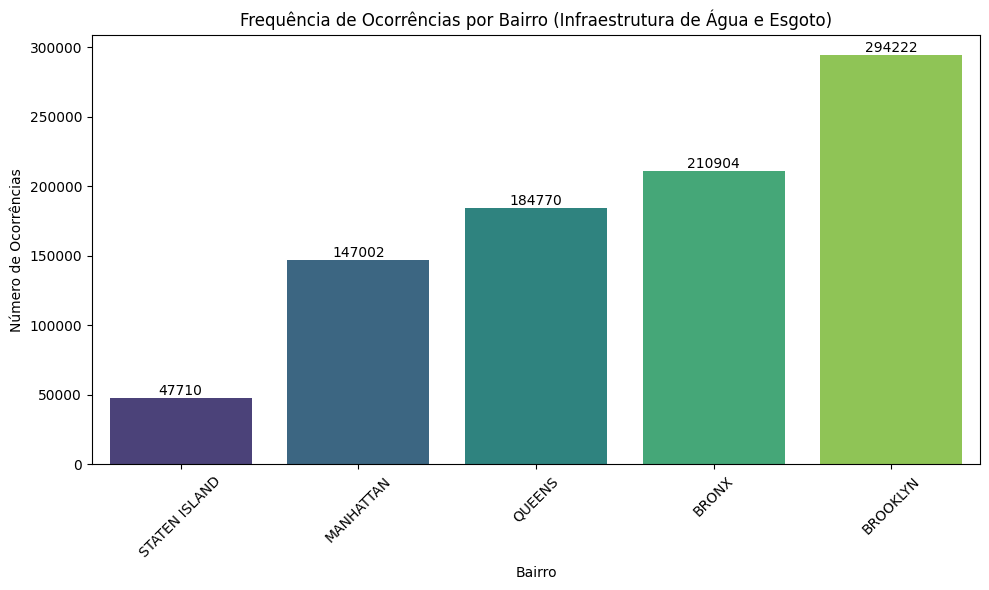

In [16]:
ocu_borough_agua_esgoto_counts.columns = ['borough', 'count']

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='borough', y='count', data=ocu_borough_agua_esgoto_counts, hue='borough', palette='viridis', dodge=False)
plt.title('Frequência de Ocorrências por Bairro (Infraestrutura de Água e Esgoto)')
plt.xlabel('Bairro')
plt.ylabel('Número de Ocorrências')
plt.xticks(rotation=45)

# Adicionar os valores dentro das barras
for patch in ax.patches:
    x = patch.get_x() + patch.get_width() / 2.0
    y = patch.get_height() + 0.5  # Ajuste para evitar sobreposição
    ax.text(x, y, int(patch.get_height()), ha='center', va='bottom', color='black', fontsize=10)

plt.tight_layout()
plt.show()


#### Ocorrências de Obra/Barulho

In [17]:
ocu_borough_build_noise = df_mod[mask_obras_ruido][['complaint_type', 'descriptor', 'borough']]
ocu_borough_build_noise_counts = ocu_borough_build_noise.groupby('borough').size().reset_index(name='count').sort_values(by='count', ascending=True)

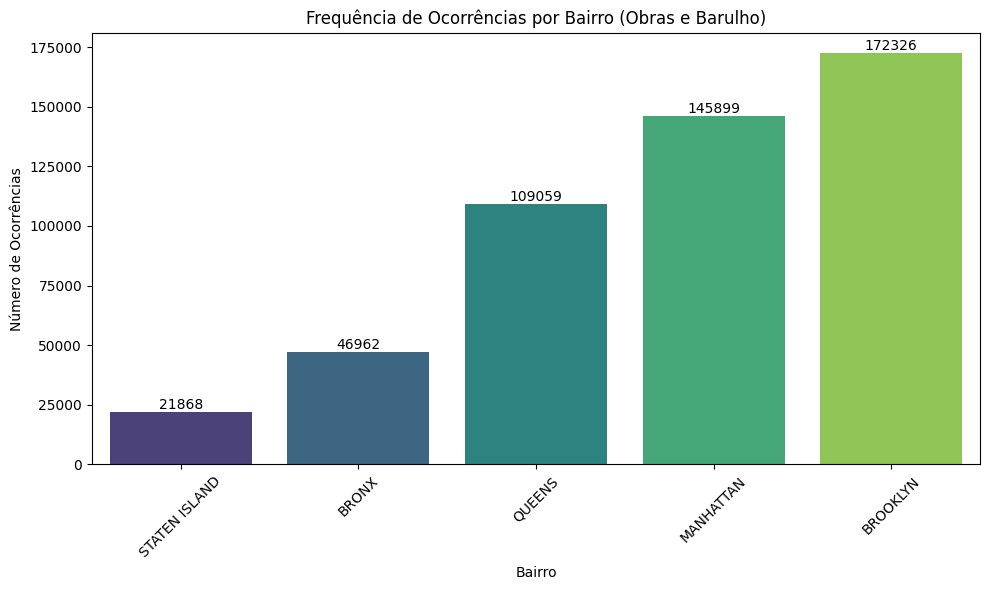

In [18]:
ocu_borough_build_noise_counts.columns = ['borough', 'count']

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='borough', y='count', data=ocu_borough_build_noise_counts, hue='borough', palette='viridis', dodge=False)
plt.title('Frequência de Ocorrências por Bairro (Obras e Barulho)')
plt.xlabel('Bairro')
plt.ylabel('Número de Ocorrências')
plt.xticks(rotation=45)

# Adicionar os valores dentro das barras
for patch in ax.patches:
    x = patch.get_x() + patch.get_width() / 2.0
    y = patch.get_height() + 0.5  # Ajuste para evitar sobreposição
    ax.text(x, y, int(patch.get_height()), ha='center', va='bottom', color='black', fontsize=10)

plt.tight_layout()
plt.show()

#### Ocorrências de insalubridade ou riscos ambientais

In [19]:
ocu_borough_insalubre = df_mod[mask_insalubre][['complaint_type', 'descriptor', 'borough']]
ocu_borough_insalubre_counts = ocu_borough_insalubre.groupby('borough').size().reset_index(name='count').sort_values(by='count', ascending=True)

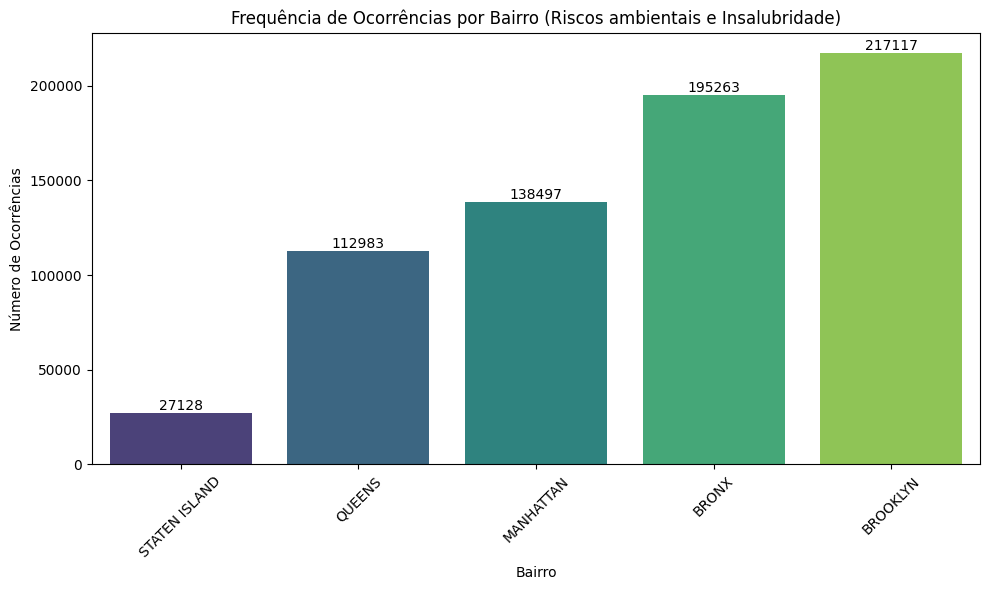

In [20]:
ocu_borough_insalubre_counts.columns = ['borough', 'count']

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='borough', y='count', data=ocu_borough_insalubre_counts, hue='borough', palette='viridis', dodge=False)
plt.title('Frequência de Ocorrências por Bairro (Riscos ambientais e Insalubridade)')
plt.xlabel('Bairro')
plt.ylabel('Número de Ocorrências')
plt.xticks(rotation=45)

# Adicionar os valores dentro das barras
for patch in ax.patches:
    x = patch.get_x() + patch.get_width() / 2.0
    y = patch.get_height() + 0.5  # Ajuste para evitar sobreposição
    ax.text(x, y, int(patch.get_height()), ha='center', va='bottom', color='black', fontsize=10)

plt.tight_layout()
plt.show()

## Quais são as ocorrencias mais frequentes por bairro?
Vamos entender quais são as ocorrências mais frequentes por bairro, vai ajudar a ter mais uma informação para a conclusão

#### Total das ocorrências

In [21]:
occurrences_by_borough = df_mod.groupby(['borough', 'descriptor']).size().reset_index(name='count')

# Selecionar os 5 casos mais frequentes por bairro
top_occurrences = occurrences_by_borough.groupby('borough').apply(lambda x: x.nlargest(5, 'count')).reset_index(drop=True)

# Criar Tree Map
fig = px.treemap(
    top_occurrences, 
    path=['borough', 'descriptor'],  # Agrupamento por Bairro e Tipo de Ocorrência
    values='count', 
    color='borough',  # Diferenciar bairros por cor
    title="Top 5 Ocorrências por Bairro (Total)",
    color_discrete_map={'Brooklyn': 'blue', 'Manhattan': 'red', 'Queens': 'green', 'Bronx': 'purple', 'Staten Island': 'orange'}
)

# Adicionar valores dentro dos blocos
fig.update_traces(texttemplate='%{label}<br>Ocorrências: %{value}', textfont_size=12)

# Ajustar layout para melhor visualização
fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))

# Exibir gráfico interativo
fig.show()

C:\Users\gabri\AppData\Local\Temp\ipykernel_16372\626826492.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_occurrences = occurrences_by_borough.groupby('borough').apply(lambda x: x.nlargest(5, 'count')).reset_index(drop=True)


#### Ocorrências eletricas

In [22]:
occurrences_by_borough = ocu_borough_ele.groupby(['borough', 'descriptor']).size().reset_index(name='count')

# Selecionar os 5 casos mais frequentes por bairro
top_occurrences = occurrences_by_borough.groupby('borough').apply(lambda x: x.nlargest(5, 'count')).reset_index(drop=True)

# Criar Tree Map
fig = px.treemap(
    top_occurrences, 
    path=['borough', 'descriptor'],  # Agrupamento por Bairro e Tipo de Ocorrência
    values='count', 
    color='borough',  # Diferenciar bairros por cor
    title="Top 5 Ocorrências por Bairro (Problemas eletricos)",
    color_discrete_map={'Brooklyn': 'blue', 'Manhattan': 'red', 'Queens': 'green', 'Bronx': 'purple', 'Staten Island': 'orange'}
)

# Adicionar valores dentro dos blocos
fig.update_traces(texttemplate='%{label}<br>Ocorrências: %{value}', textfont_size=12)

# Ajustar layout para melhor visualização
fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))

# Exibir gráfico interativo
fig.show()

C:\Users\gabri\AppData\Local\Temp\ipykernel_16372\511856314.py:4: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



#### Ocorrência de Agua/Esgoto

In [23]:
occurrences_by_borough = ocu_borough_agua_esgoto.groupby(['borough', 'descriptor']).size().reset_index(name='count')

# Selecionar os 5 casos mais frequentes por bairro
top_occurrences = occurrences_by_borough.groupby('borough').apply(lambda x: x.nlargest(5, 'count')).reset_index(drop=True)

# Criar Tree Map
fig = px.treemap(
    top_occurrences, 
    path=['borough', 'descriptor'],  # Agrupamento por Bairro e Tipo de Ocorrência
    values='count', 
    color='borough',  # Diferenciar bairros por cor
    title="Top 5 Ocorrências por Bairro (Agua e Esgoto)",
    color_discrete_map={'Brooklyn': 'blue', 'Manhattan': 'red', 'Queens': 'green', 'Bronx': 'purple', 'Staten Island': 'orange'}
)

# Adicionar valores dentro dos blocos
fig.update_traces(texttemplate='%{label}<br>Ocorrências: %{value}', textfont_size=12)

# Ajustar layout para melhor visualização
fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))

# Exibir gráfico interativo
fig.show()

C:\Users\gabri\AppData\Local\Temp\ipykernel_16372\3607761345.py:4: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



#### Ocorrências de Obra/Barulho

In [24]:
occurrences_by_borough = ocu_borough_build_noise.groupby(['borough', 'descriptor']).size().reset_index(name='count')

# Selecionar os 5 casos mais frequentes por bairro
top_occurrences = occurrences_by_borough.groupby('borough').apply(lambda x: x.nlargest(5, 'count')).reset_index(drop=True)

# Criar Tree Map
fig = px.treemap(
    top_occurrences, 
    path=['borough', 'descriptor'],  # Agrupamento por Bairro e Tipo de Ocorrência
    values='count', 
    color='borough',  # Diferenciar bairros por cor
    title="Top 5 Ocorrências por Bairro (Obra e Barulho)",
    color_discrete_map={'Brooklyn': 'blue', 'Manhattan': 'red', 'Queens': 'green', 'Bronx': 'purple', 'Staten Island': 'orange'}
)

# Adicionar valores dentro dos blocos
fig.update_traces(texttemplate='%{label}<br>Ocorrências: %{value}', textfont_size=12)

# Ajustar layout para melhor visualização
fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))

# Exibir gráfico interativo
fig.show()

C:\Users\gabri\AppData\Local\Temp\ipykernel_16372\3955964274.py:4: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



#### Ocorrências de insalubridade ou riscos ambientais

In [25]:
occurrences_by_borough = ocu_borough_insalubre.groupby(['borough', 'descriptor']).size().reset_index(name='count')

# Selecionar os 5 casos mais frequentes por bairro
top_occurrences = occurrences_by_borough.groupby('borough').apply(lambda x: x.nlargest(5, 'count')).reset_index(drop=True)

# Criar Tree Map
fig = px.treemap(
    top_occurrences, 
    path=['borough', 'descriptor'],  # Agrupamento por Bairro e Tipo de Ocorrência
    values='count', 
    color='borough',  # Diferenciar bairros por cor
    title="Top 5 Ocorrências por Bairro (Insalubridade / Riscos ambientais)",
    color_discrete_map={'Brooklyn': 'blue', 'Manhattan': 'red', 'Queens': 'green', 'Bronx': 'purple', 'Staten Island': 'orange'}
)

# Adicionar valores dentro dos blocos
fig.update_traces(texttemplate='%{label}<br>Ocorrências: %{value}', textfont_size=12)

# Ajustar layout para melhor visualização
fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))

# Exibir gráfico interativo
fig.show()

C:\Users\gabri\AppData\Local\Temp\ipykernel_16372\1013731241.py:4: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



# Tempo de conclusão das ocorrencias

### Consultar apenas as ocorrências que foram declaradas como concluidas
Já que vamos analisar o tempo medio de resolução dos problemas, é importante verificar apenas ocorrências que foram finalizadas.

##### Total

In [26]:
total_temp_ocu = df_mod[['complaint_type', 'descriptor', 'borough', 'status', 'created_date','closed_date']]
total_temp_ocu_counts = total_temp_ocu.groupby('borough').size().reset_index(name='count').sort_values(by='count', ascending=False)

In [27]:
total_fechados = total_temp_ocu.copy()

# Filtrar apenas as ocorrências que foram fechadas (status == 'Closed')
total_fechados = total_fechados[total_fechados['status'] == 'Closed']

# Converter as colunas de data para datetime
total_fechados['created_date'] = pd.to_datetime(total_fechados['created_date'], format='%m/%d/%Y %I:%M:%S %p')
total_fechados['closed_date'] = pd.to_datetime(total_fechados['closed_date'], format='%m/%d/%Y %I:%M:%S %p')

##### Ocorrências Eletricas

In [28]:
eletricos_temp_ocu = df_mod[mask_eletricos][['complaint_type', 'descriptor', 'borough', 'status', 'created_date','closed_date']]
eletricos_temp_ocu_counts = eletricos_temp_ocu.groupby('borough').size().reset_index(name='count').sort_values(by='count', ascending=False)

In [29]:
eletricos_fechados = eletricos_temp_ocu.copy()

# Filtrar apenas as ocorrências que foram fechadas (status == 'Closed')
eletricos_fechados = eletricos_fechados[eletricos_fechados['status'] == 'Closed']

# Converter as colunas de data para datetime
eletricos_fechados['created_date'] = pd.to_datetime(eletricos_fechados['created_date'], format='%m/%d/%Y %I:%M:%S %p')
eletricos_fechados['closed_date'] = pd.to_datetime(eletricos_fechados['closed_date'], format='%m/%d/%Y %I:%M:%S %p')

##### Ocorrências de Agua/Esgoto

In [30]:
agua_esgoto_temp_ocu = df_mod[mask_agua_esgoto][['complaint_type', 'descriptor', 'borough', 'status', 'created_date','closed_date']]
agua_esgoto_temp_ocu_counts = agua_esgoto_temp_ocu.groupby('borough').size().reset_index(name='count').sort_values(by='count', ascending=False)

In [31]:
agua_esgoto_fechados = agua_esgoto_temp_ocu.copy()

# Filtrar apenas as ocorrências que foram fechadas (status == 'Closed')
agua_esgoto_fechados = agua_esgoto_fechados[agua_esgoto_fechados['status'] == 'Closed']

# Converter as colunas de data para datetime
agua_esgoto_fechados['created_date'] = pd.to_datetime(agua_esgoto_fechados['created_date'], format='%m/%d/%Y %I:%M:%S %p')
agua_esgoto_fechados['closed_date'] = pd.to_datetime(agua_esgoto_fechados['closed_date'], format='%m/%d/%Y %I:%M:%S %p')

##### Ocorrências de Obra/Barulho

In [32]:
obras_ruido_temp_ocu = df_mod[mask_obras_ruido][['complaint_type', 'descriptor', 'borough', 'status', 'created_date','closed_date']]
obras_ruido_temp_ocu_counts = obras_ruido_temp_ocu.groupby('borough').size().reset_index(name='count').sort_values(by='count', ascending=False)

In [33]:
obras_ruido_fechados = obras_ruido_temp_ocu.copy()

# Filtrar apenas as ocorrências que foram fechadas (status == 'Closed')
obras_ruido_fechados = obras_ruido_fechados[obras_ruido_fechados['status'] == 'Closed']

# Converter as colunas de data para datetime
obras_ruido_fechados['created_date'] = pd.to_datetime(obras_ruido_fechados['created_date'], format='%m/%d/%Y %I:%M:%S %p')
obras_ruido_fechados['closed_date'] = pd.to_datetime(obras_ruido_fechados['closed_date'], format='%m/%d/%Y %I:%M:%S %p')

##### Ocorrências de insalubridade ou riscos ambientais

In [34]:
insalubre_env_temp_ocu = df_mod[mask_insalubre][['complaint_type', 'descriptor', 'borough', 'status', 'created_date','closed_date']]
insalubre_env_temp_ocu_counts = insalubre_env_temp_ocu.groupby('borough').size().reset_index(name='count').sort_values(by='count', ascending=False)

In [35]:
insalubre_env_fechados = insalubre_env_temp_ocu.copy()

# Filtrar apenas as ocorrências que foram fechadas (status == 'Closed')
insalubre_env_fechados = insalubre_env_fechados[insalubre_env_fechados['status'] == 'Closed']

# Converter as colunas de data para datetime
insalubre_env_fechados['created_date'] = pd.to_datetime(insalubre_env_fechados['created_date'], format='%m/%d/%Y %I:%M:%S %p')
insalubre_env_fechados['closed_date'] = pd.to_datetime(insalubre_env_fechados['closed_date'], format='%m/%d/%Y %I:%M:%S %p')

### Quanto tempo demora para restabelecer cada serviço?

#### Serviços gerais
O tempo médio de resolução indica a eficiência das autoridades em lidar com problemas críticos. Para um datacenter, falhas prolongadas em energia, água, esgoto ou infraestrutura podem causar interrupções graves e custos elevados. Locais com resolução rápida são mais confiáveis e reduzem riscos operacionais.

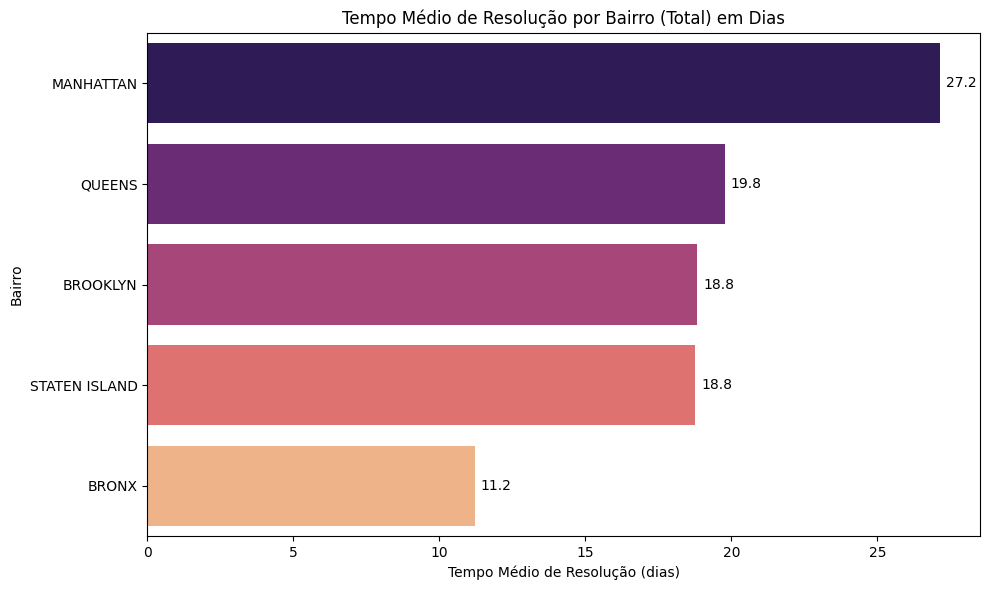

In [36]:
# Calcular o tempo de resolução em horas
total_fechados['resolution_time'] = (
    (total_fechados['closed_date'] - total_fechados['created_date']).dt.total_seconds() / 3600
)

# Remover valores negativos (casos com erro nos dados)
total_fechados = total_fechados[total_fechados['resolution_time'] >= 0]

# Agrupar por bairro e calcular estatísticas do tempo de resolução
resolution_stats = total_fechados.groupby('borough')['resolution_time'].agg(['mean', 'median', 'count']).reset_index()

# Renomear colunas para melhor compreensão
resolution_stats.columns = ['borough', 'avg_resolution_time_hours', 'median_resolution_time_hours', 'total_cases']

# Converter o tempo médio de resolução para dias
resolution_stats['avg_resolution_time_days'] = resolution_stats['avg_resolution_time_hours'] / 24

# Ordenar bairros pelo menor tempo médio de resolução (em dias)
resolution_stats = resolution_stats.sort_values(by='avg_resolution_time_days', ascending=False)

# Exibir o gráfico
plt.figure(figsize=(10, 6))

ax = sns.barplot(
    data=resolution_stats,
    y='borough',  # Inverter eixos: 'borough' agora é Y
    x='avg_resolution_time_days',  # 'avg_resolution_time_days' agora é X
    hue='borough',  # Manter a diferenciação por bairro
    order=resolution_stats['borough'],  # Ordem mantida
    palette='magma'
)

plt.title('Tempo Médio de Resolução por Bairro (Total) em Dias')
plt.ylabel('Bairro')  # Agora no eixo Y
plt.xlabel('Tempo Médio de Resolução (dias)')  # Agora no eixo X

# Adicionar valores dentro das barras
for patch in ax.patches:
    x = patch.get_width() + 0.2  # Ajuste para exibir o número ao lado da barra
    y = patch.get_y() + patch.get_height() / 2
    ax.text(x, y, f"{patch.get_width():.1f}", ha='left', va='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()

#### Serviço de Energia
O tempo para restabelecer o serviço relacionado à energia é crucial para um data center, pois períodos prolongados de interrupção podem resultar em perda de dados, falha de serviços e altos custos operacionais. Regiões com tempos de resolução mais curtos indicam uma infraestrutura mais confiável e uma resposta mais eficiente a falhas elétricas, reduzindo os riscos de downtime.

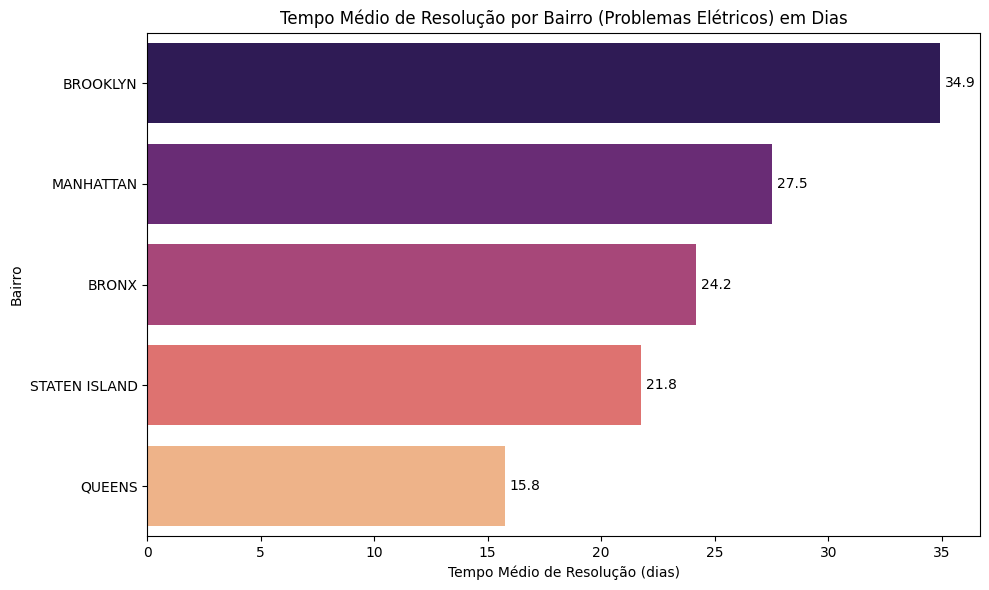

In [37]:
# Calcular o tempo de resolução em horas
eletricos_fechados['resolution_time'] = (
    (eletricos_fechados['closed_date'] - eletricos_fechados['created_date']).dt.total_seconds() / 3600
)

# Remover valores negativos (casos com erro nos dados)
eletricos_fechados = eletricos_fechados[eletricos_fechados['resolution_time'] >= 0]

# Agrupar por bairro e calcular estatísticas do tempo de resolução
resolution_stats = eletricos_fechados.groupby('borough')['resolution_time'].agg(['mean', 'median', 'count']).reset_index()

# Renomear colunas para melhor compreensão
resolution_stats.columns = ['borough', 'avg_resolution_time_hours', 'median_resolution_time_hours', 'total_cases']

# Converter o tempo médio de resolução para dias
resolution_stats['avg_resolution_time_days'] = resolution_stats['avg_resolution_time_hours'] / 24

# Ordenar bairros pelo menor tempo médio de resolução (em dias)
resolution_stats = resolution_stats.sort_values(by='avg_resolution_time_days', ascending=False)

# Exibir o gráfico
plt.figure(figsize=(10, 6))

ax = sns.barplot(
    data=resolution_stats,
    y='borough',  # Inverter eixos: 'borough' agora é Y
    x='avg_resolution_time_days',  # 'avg_resolution_time_days' agora é X
    hue='borough',  # Manter a diferenciação por bairro
    order=resolution_stats['borough'],  # Ordem mantida
    palette='magma'
)

plt.title('Tempo Médio de Resolução por Bairro (Problemas Elétricos) em Dias')
plt.ylabel('Bairro')  # Agora no eixo Y
plt.xlabel('Tempo Médio de Resolução (dias)')  # Agora no eixo X

# Adicionar valores dentro das barras
for patch in ax.patches:
    x = patch.get_width() + 0.2  # Ajuste para exibir o número ao lado da barra
    y = patch.get_y() + patch.get_height() / 2
    ax.text(x, y, f"{patch.get_width():.1f}", ha='left', va='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()

#### Serviços de Agua/Esgoto
Entender o tempo de resolução dos problemas de água e esgoto é essencial para avaliar o impacto potencial de falhas hídricas na operação do datacenter. Vazamentos, alagamentos ou problemas de drenagem podem causar danos estruturais, curto-circuitos e falhas no resfriamento, aumentando o risco de paralisações. Se a resposta das autoridades for lenta, o tempo de inatividade e os custos de mitigação podem ser elevados, tornando a área menos viável para instalação.

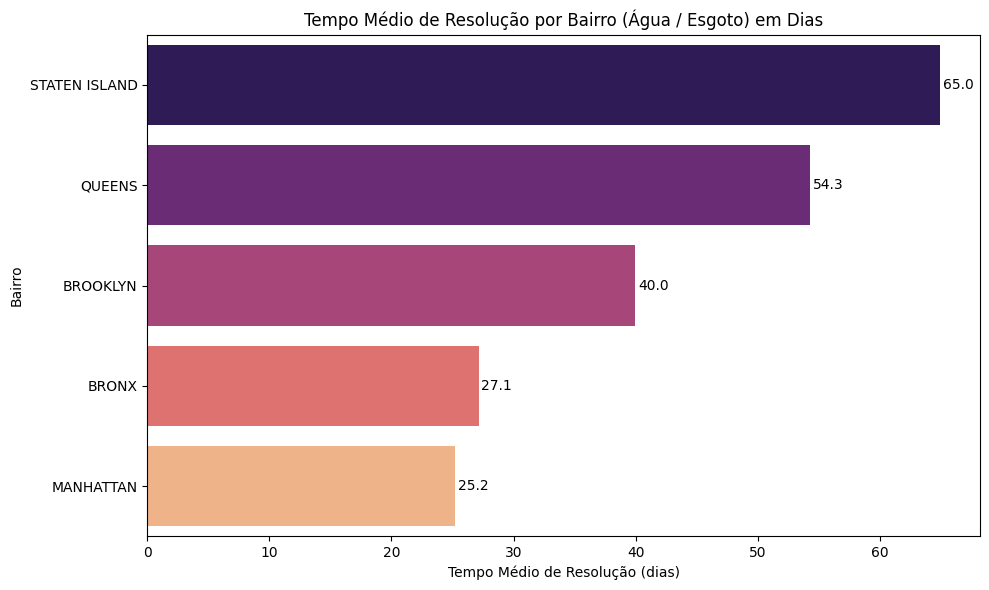

In [38]:
# Calcular o tempo de resolução em horas
agua_esgoto_fechados['resolution_time'] = (
    (agua_esgoto_fechados['closed_date'] - agua_esgoto_fechados['created_date']).dt.total_seconds() / 3600
)

# Remover valores negativos (casos com erro nos dados)
agua_esgoto_fechados = agua_esgoto_fechados[agua_esgoto_fechados['resolution_time'] >= 0]

# Agrupar por bairro e calcular estatísticas do tempo de resolução
resolution_stats = agua_esgoto_fechados.groupby('borough')['resolution_time'].agg(['mean', 'median', 'count']).reset_index()

# Renomear colunas para melhor compreensão
resolution_stats.columns = ['borough', 'avg_resolution_time_hours', 'median_resolution_time_hours', 'total_cases']

# Converter o tempo médio de resolução para dias
resolution_stats['avg_resolution_time_days'] = resolution_stats['avg_resolution_time_hours'] / 24

# Ordenar bairros pelo menor tempo médio de resolução (em dias)
resolution_stats = resolution_stats.sort_values(by='avg_resolution_time_days', ascending=False)

plt.figure(figsize=(10, 6))

ax = sns.barplot(
    data=resolution_stats,
    y='borough',  # Inverter eixos: 'borough' agora é Y
    x='avg_resolution_time_days',  # 'avg_resolution_time_days' agora é X
    hue='borough',  # Manter a diferenciação por bairro
    order=resolution_stats['borough'],  # Ordem mantida
    palette='magma'
)

plt.title('Tempo Médio de Resolução por Bairro (Água / Esgoto) em Dias')
plt.ylabel('Bairro')  # Agora no eixo Y
plt.xlabel('Tempo Médio de Resolução (dias)')  # Agora no eixo X

# Adicionar valores dentro das barras
for patch in ax.patches:
    x = patch.get_width() + 0.2  # Ajuste para exibir o número ao lado da barra
    y = patch.get_y() + patch.get_height() / 2
    ax.text(x, y, f"{patch.get_width():.1f}", ha='left', va='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()

#### Serviços de Obra/Barulho
O barulho e as obras podem impactar um datacenter de várias formas:

- Vibrações e impacto nos servidores – Construções próximas podem gerar vibrações que afetam a integridade dos equipamentos sensíveis, como racks de servidores e discos rígidos.
- Ruído excessivo – Pode interferir no ambiente de trabalho da equipe de manutenção e até na performance de sensores acústicos usados no monitoramento de hardware.
- Interrupções operacionais – Obras frequentes podem causar cortes de energia, bloqueios no acesso ao local e até danos à infraestrutura de fibra óptica e rede elétrica.
- Manutenção e segurança – Se a região tem muitas obras, há um risco maior de escavações que podem atingir cabos subterrâneos, exigindo reparos e aumentando custos operacionais.

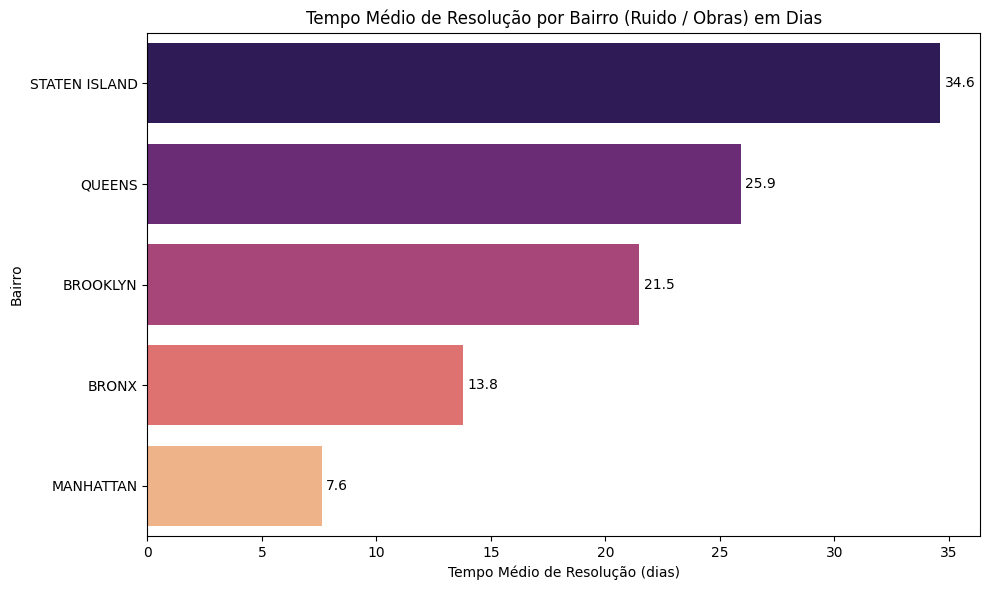

In [39]:
obras_ruido_fechados['resolution_time'] = (
    (obras_ruido_fechados['closed_date'] - obras_ruido_fechados['created_date']).dt.total_seconds() / 3600
)

obras_ruido_fechados = obras_ruido_fechados[obras_ruido_fechados['resolution_time'] >= 0]

resolution_stats = obras_ruido_fechados.groupby('borough')['resolution_time'].agg(['mean', 'median', 'count']).reset_index()

resolution_stats.columns = ['borough', 'avg_resolution_time_hours', 'median_resolution_time_hours', 'total_cases']

resolution_stats['avg_resolution_time_days'] = resolution_stats['avg_resolution_time_hours'] / 24

resolution_stats = resolution_stats.sort_values(by='avg_resolution_time_days', ascending=False)

plt.figure(figsize=(10, 6))

ax = sns.barplot(
    data=resolution_stats,
    y='borough', 
    x='avg_resolution_time_days',
    hue='borough', 
    order=resolution_stats['borough'],
    palette='magma'
)

plt.title('Tempo Médio de Resolução por Bairro (Ruido / Obras) em Dias')
plt.ylabel('Bairro') 
plt.xlabel('Tempo Médio de Resolução (dias)')

for patch in ax.patches:
    x = patch.get_width() + 0.2 
    y = patch.get_y() + patch.get_height() / 2
    ax.text(x, y, f"{patch.get_width():.1f}", ha='left', va='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()

#### Serviços de insalubridade ou riscos ambientais
Problemas ambientais e condições insalubres podem afetar um datacenter ao comprometer a qualidade do ar, a refrigeração e a segurança dos equipamentos. Poluição, infestação de pragas e resíduos tóxicos podem aumentar custos de manutenção e impactar a longevidade dos servidores. Além disso, áreas com alto índice de contaminação podem ter restrições ambientais que dificultam a operação.

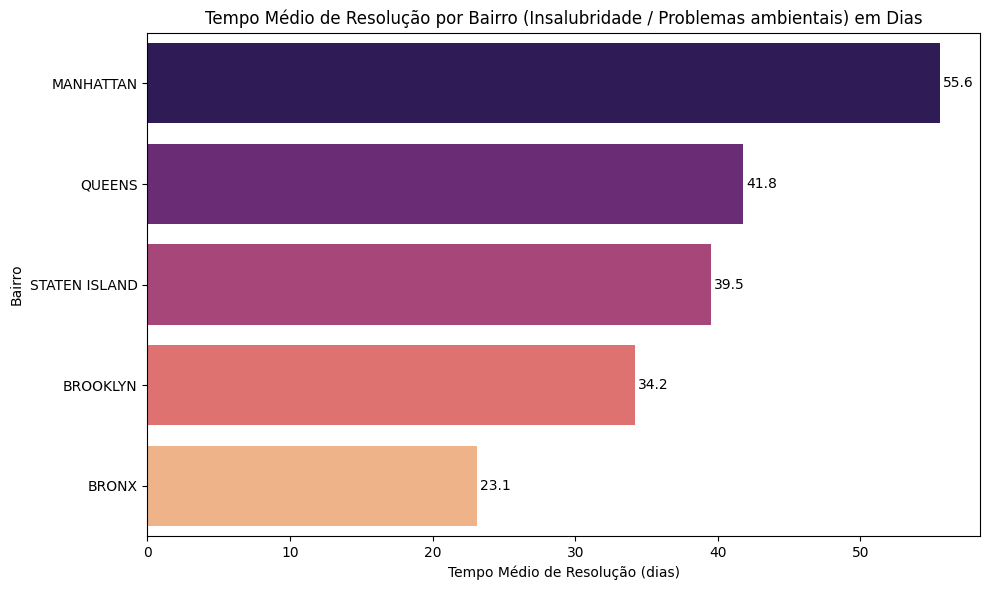

In [40]:
insalubre_env_fechados['resolution_time'] = (
    (insalubre_env_fechados['closed_date'] - insalubre_env_fechados['created_date']).dt.total_seconds() / 3600
)

insalubre_env_fechados = insalubre_env_fechados[insalubre_env_fechados['resolution_time'] >= 0]

resolution_stats = insalubre_env_fechados.groupby('borough')['resolution_time'].agg(['mean', 'median', 'count']).reset_index()

resolution_stats.columns = ['borough', 'avg_resolution_time_hours', 'median_resolution_time_hours', 'total_cases']


resolution_stats['avg_resolution_time_days'] = resolution_stats['avg_resolution_time_hours'] / 24


resolution_stats = resolution_stats.sort_values(by='avg_resolution_time_days', ascending=False)

plt.figure(figsize=(10, 6))

ax = sns.barplot(
    data=resolution_stats,
    y='borough',
    x='avg_resolution_time_days', 
    hue='borough',
    order=resolution_stats['borough'], 
    palette='magma'
)

plt.title('Tempo Médio de Resolução por Bairro (Insalubridade / Problemas ambientais) em Dias')
plt.ylabel('Bairro')
plt.xlabel('Tempo Médio de Resolução (dias)')  

for patch in ax.patches:
    x = patch.get_width() + 0.2  
    y = patch.get_y() + patch.get_height() / 2
    ax.text(x, y, f"{patch.get_width():.1f}", ha='left', va='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()

### Qual é o tempo medio de resolução para cada tipo de ocorrência?
O tempo médio de resolução indica a eficiência das autoridades em lidar com problemas críticos. Para um datacenter, falhas prolongadas em energia, água, esgoto ou infraestrutura podem causar interrupções graves e custos elevados. Locais com resolução rápida são mais confiáveis e reduzem riscos operacionais.

#### Total

#### Ocorrências Eletricas

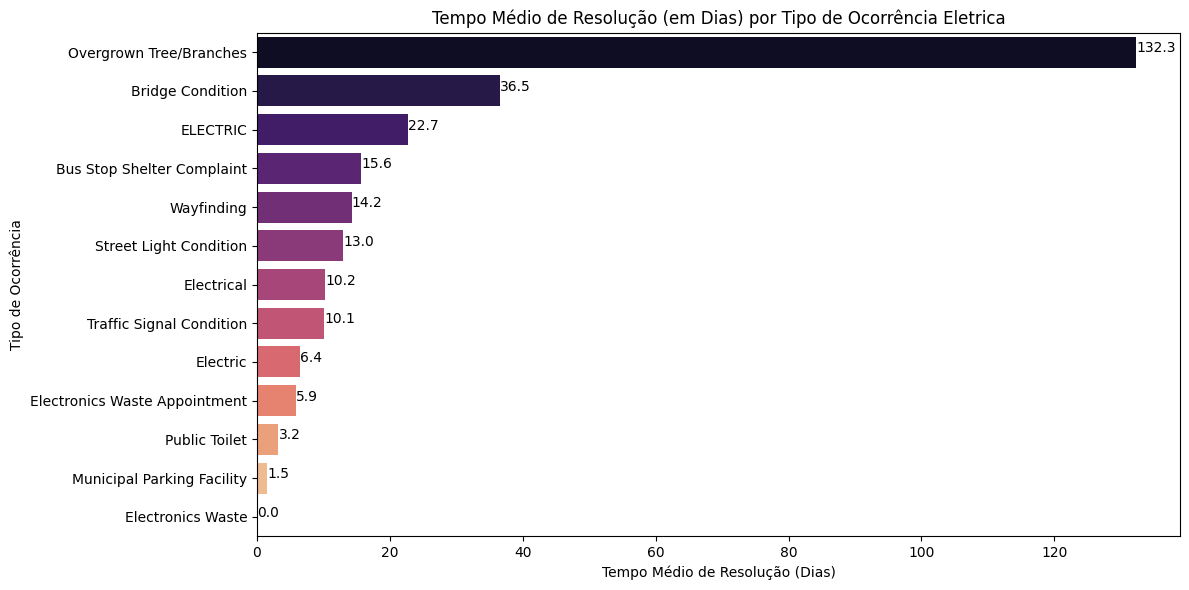

In [41]:
resolution_by_complaint = eletricos_fechados.groupby('complaint_type')['resolution_time'].mean().reset_index()
#Remover um ruido do grafico que não contribui com a analise
resolution_by_complaint = resolution_by_complaint[resolution_by_complaint['complaint_type'] != 'Food Establishment']
resolution_by_complaint['resolution_time_days'] = resolution_by_complaint['resolution_time'] / 24
resolution_by_complaint = resolution_by_complaint.sort_values(by='resolution_time_days', ascending=False)

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x='resolution_time_days', 
    y='complaint_type', 
    data=resolution_by_complaint, 
    hue='complaint_type',  
    palette='magma',
)

for patch in ax.patches:
    ax.text(patch.get_width() + 0.05, 
            patch.get_y() + patch.get_height() / 2,
            f"{patch.get_width():.1f}", 
            ha='left', fontsize=10, color='black')

plt.title('Tempo Médio de Resolução (em Dias) por Tipo de Ocorrência Eletrica')
plt.xlabel('Tempo Médio de Resolução (Dias)')
plt.ylabel('Tipo de Ocorrência')
plt.tight_layout()
plt.show()

#### Ocorrências de Agua/Esgoto

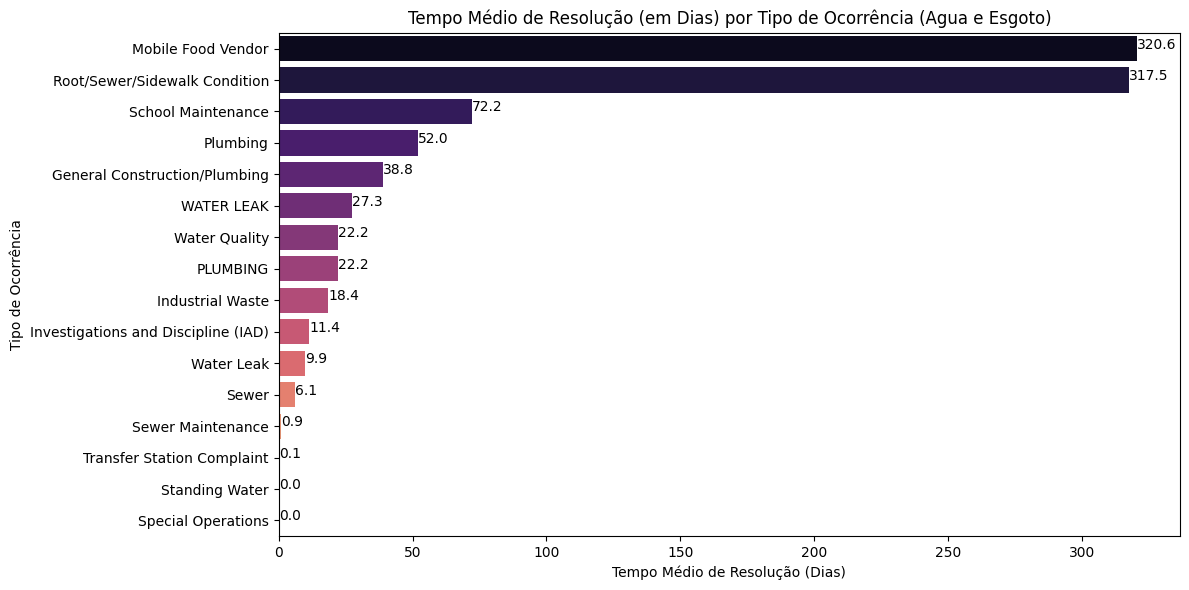

In [42]:
resolution_by_complaint = agua_esgoto_fechados.groupby('complaint_type')['resolution_time'].mean().reset_index()
#Remover um ruido do grafico que não contribui com a analise
resolution_by_complaint = resolution_by_complaint[resolution_by_complaint['complaint_type'] != 'Food Establishment']
resolution_by_complaint['resolution_time_days'] = resolution_by_complaint['resolution_time'] / 24
resolution_by_complaint = resolution_by_complaint.sort_values(by='resolution_time_days', ascending=False)

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x='resolution_time_days', 
    y='complaint_type', 
    data=resolution_by_complaint, 
    hue='complaint_type',  
    palette='magma',
)

for patch in ax.patches:
    ax.text(patch.get_width() + 0.05, 
            patch.get_y() + patch.get_height() / 2,
            f"{patch.get_width():.1f}", 
            ha='left', fontsize=10, color='black')

plt.title('Tempo Médio de Resolução (em Dias) por Tipo de Ocorrência (Agua e Esgoto)')
plt.xlabel('Tempo Médio de Resolução (Dias)')
plt.ylabel('Tipo de Ocorrência')
plt.tight_layout()
plt.show()

#### Ocorrências de Obra/Barulho

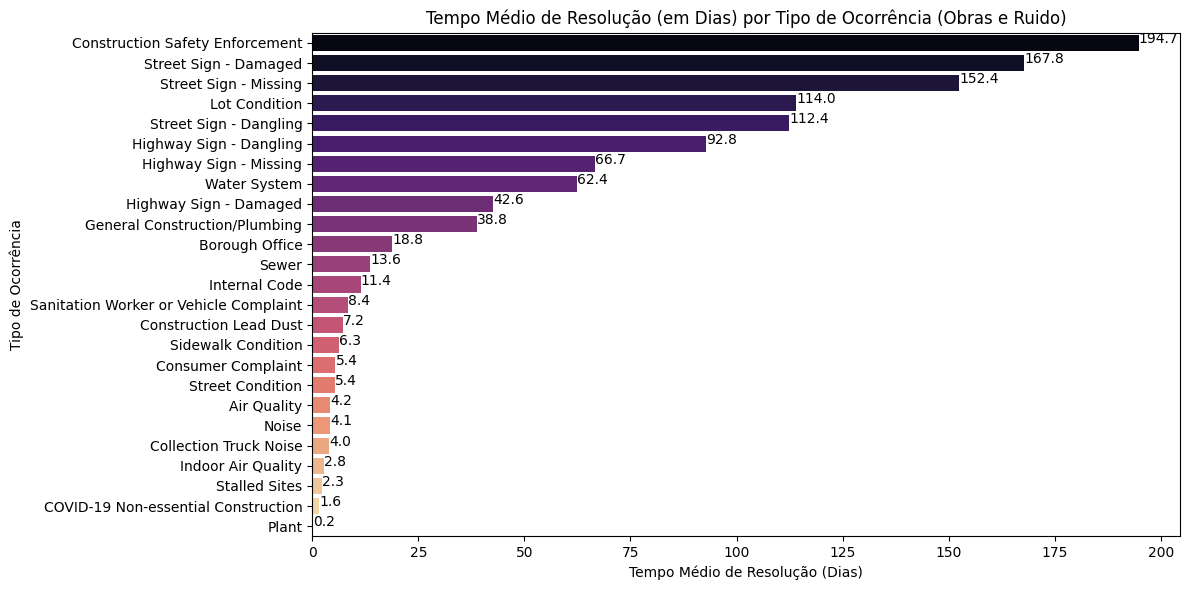

In [43]:
resolution_by_complaint = obras_ruido_fechados.groupby('complaint_type')['resolution_time'].mean().reset_index()
#Remover um ruido do grafico que não contribui com a analise
resolution_by_complaint = resolution_by_complaint[resolution_by_complaint['complaint_type'] != 'Food Establishment']
resolution_by_complaint['resolution_time_days'] = resolution_by_complaint['resolution_time'] / 24
resolution_by_complaint = resolution_by_complaint.sort_values(by='resolution_time_days', ascending=False)

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x='resolution_time_days', 
    y='complaint_type', 
    data=resolution_by_complaint, 
    hue='complaint_type',  
    palette='magma',
)

for patch in ax.patches:
    ax.text(patch.get_width() + 0.05, 
            patch.get_y() + patch.get_height() / 2,
            f"{patch.get_width():.1f}", 
            ha='left', fontsize=10, color='black')

plt.title('Tempo Médio de Resolução (em Dias) por Tipo de Ocorrência (Obras e Ruido)')
plt.xlabel('Tempo Médio de Resolução (Dias)')
plt.ylabel('Tipo de Ocorrência')
plt.tight_layout()
plt.show()

#### Ocorrências de insalubridade ou riscos ambientais

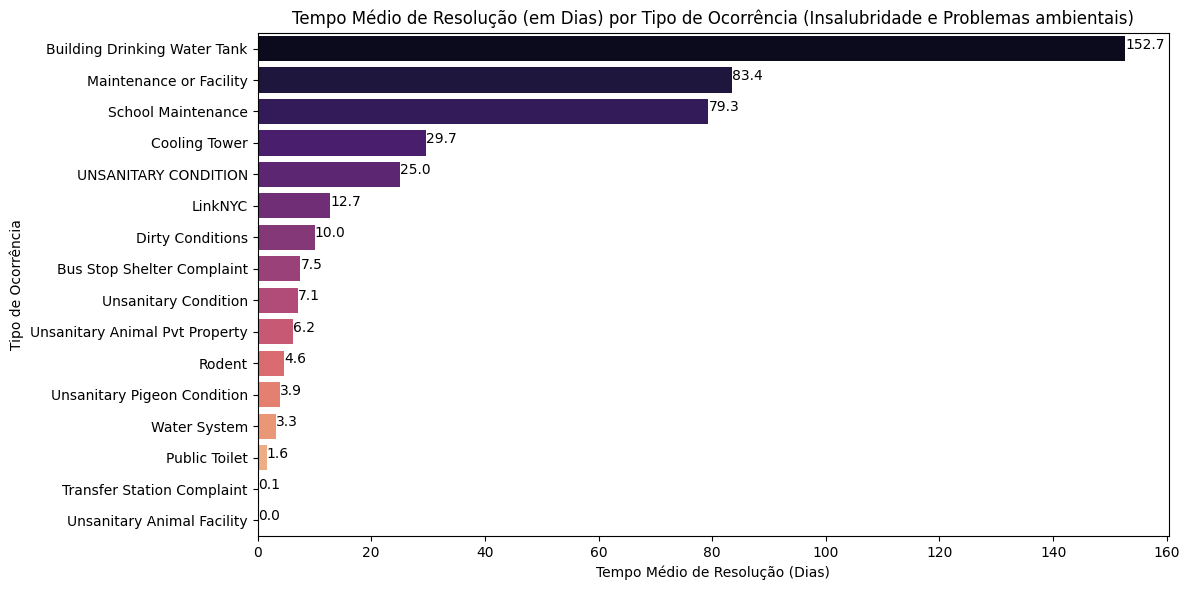

In [44]:
resolution_by_complaint = insalubre_env_fechados.groupby('complaint_type')['resolution_time'].mean().reset_index()
#Remover um ruido do grafico que não contribui com a analise
resolution_by_complaint = resolution_by_complaint[
    ~resolution_by_complaint['complaint_type'].isin(['Food Establishment', 'Tattooing'])
]
resolution_by_complaint['resolution_time_days'] = resolution_by_complaint['resolution_time'] / 24
resolution_by_complaint = resolution_by_complaint.sort_values(by='resolution_time_days', ascending=False)

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x='resolution_time_days', 
    y='complaint_type', 
    data=resolution_by_complaint, 
    hue='complaint_type',  
    palette='magma',
)

for patch in ax.patches:
    ax.text(patch.get_width() + 0.05, 
            patch.get_y() + patch.get_height() / 2,
            f"{patch.get_width():.1f}", 
            ha='left', fontsize=10, color='black')

plt.title('Tempo Médio de Resolução (em Dias) por Tipo de Ocorrência (Insalubridade e Problemas ambientais)')
plt.xlabel('Tempo Médio de Resolução (Dias)')
plt.ylabel('Tipo de Ocorrência')
plt.tight_layout()
plt.show()

### Qual a taxa de conclusão dos chamados?

A taxa de conclusão dos chamados indica a eficiência das autoridades locais na resolução de problemas críticos. Para um datacenter, isso é essencial porque:

- Alta taxa de conclusão -> Significa que falhas em energia, esgoto, infraestrutura ou segurança são resolvidas rapidamente, tornando a região mais confiável.
- Baixa taxa de conclusão ->  Indica que os problemas podem persistir por longos períodos, aumentando o risco de interrupções operacionais e custos extras com soluções emergenciais.

Ao analisar essa métrica, podemos escolher um local onde as ocorrências são tratadas de forma eficiente, garantindo maior estabilidade e menor impacto operacional para o datacenter.

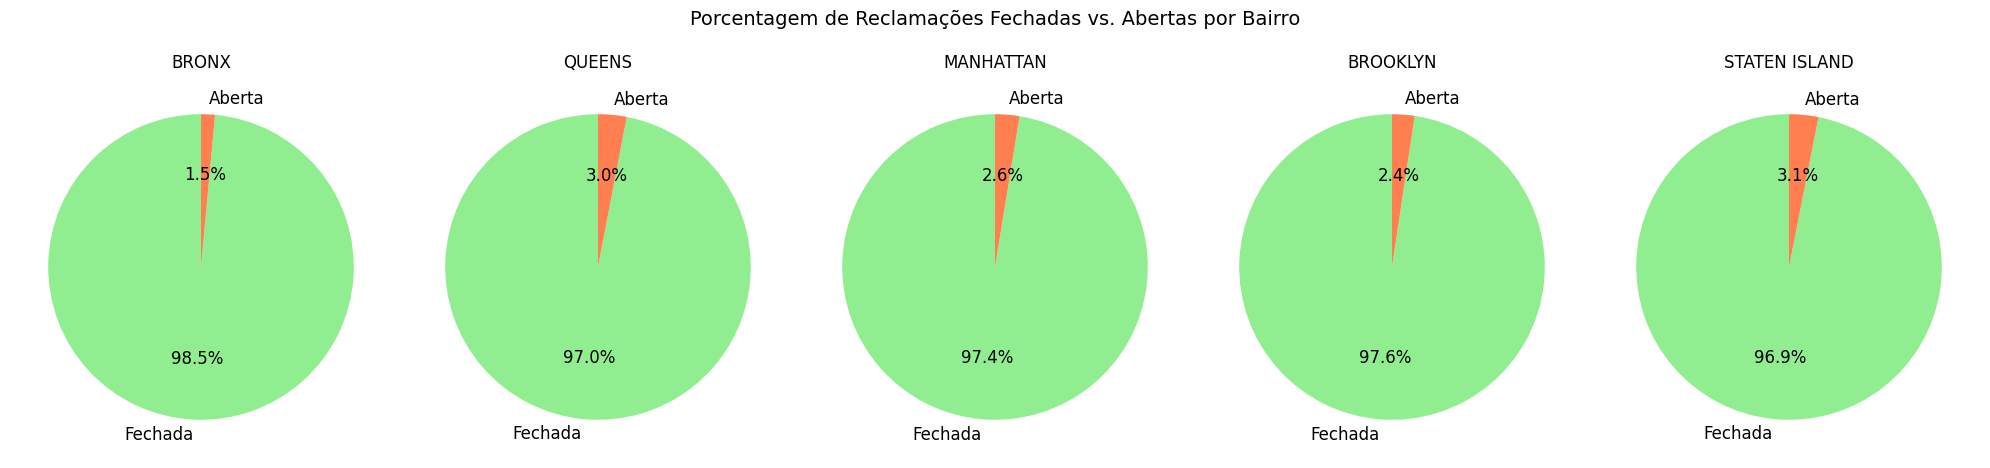

In [45]:
df_status = total_temp_ocu.copy()

# Converter datas para datetime
df_status['created_date'] = pd.to_datetime(df_status['created_date'], format='%m/%d/%Y %I:%M:%S %p')
df_status['closed_date'] = pd.to_datetime(df_status['closed_date'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')

# Criar coluna para o tempo de resolução em dias
df_status['resolution_time_days'] = (df_status['closed_date'] - df_status['created_date']).dt.total_seconds() / (60 * 60 * 24)

# Criar coluna de status simplificado
df_status['status_simplified'] = df_status['status'].apply(lambda x: 'Fechada' if x == 'Closed' else 'Aberta')

# Lista de bairros únicos
boroughs = df_status['borough'].unique()

# Criar subplots dinamicamente com base no número de bairros
fig, axes = plt.subplots(nrows=1, ncols=len(boroughs), figsize=(len(boroughs) * 4, 5))

# Criar um gráfico de pizza para cada bairro
for ax, borough in zip(axes, boroughs):
    borough_data = df_status[df_status['borough'] == borough]
    status_counts = borough_data['status_simplified'].value_counts(normalize=True) * 100

    ax.pie(
        status_counts, 
        labels=status_counts.index, 
        autopct='%1.1f%%', 
        colors=['lightgreen', 'coral'], 
        startangle=90, 
        textprops={'color': 'black', 'fontsize': 12}
    )
    ax.set_title(f'{borough}')

# Ajustar layout
plt.suptitle('Porcentagem de Reclamações Fechadas vs. Abertas por Bairro', fontsize=14)
plt.tight_layout()
plt.show()


### Qual a distribuição do periodo de conclusão dos chamados?

Entender a distribuição do tempo de conclusão permite avaliar quão rápido ou lento os problemas são resolvidos e identificar padrões de ineficiência. Para um datacenter, ocorrências que demoram meses ou anos para serem resolvidas indicam alto risco operacional, enquanto resoluções rápidas tornam a região mais confiável e segura

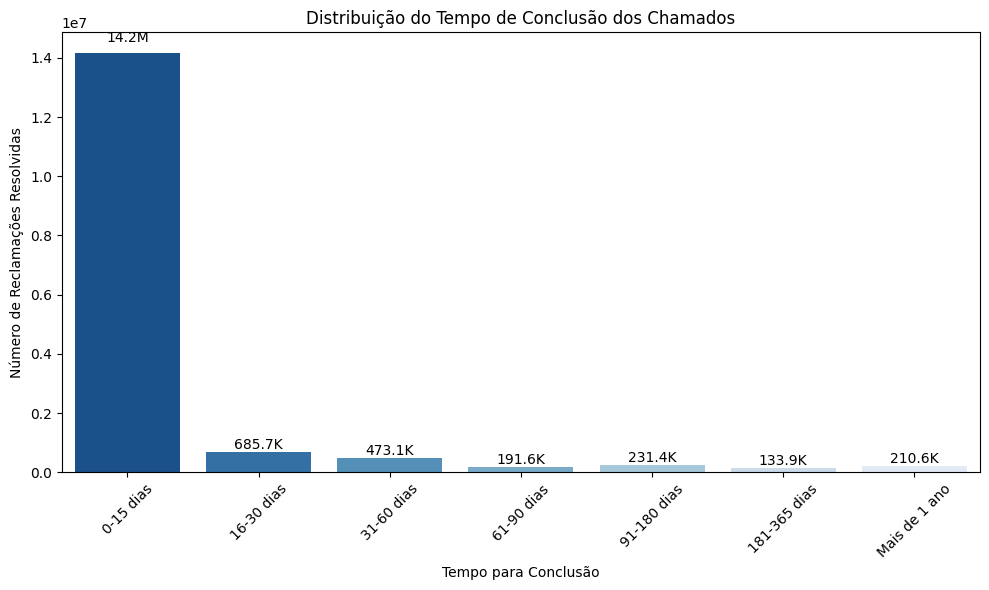

In [46]:
# Filtrar apenas os casos com status 'Closed'
closed_cases = df_status[df_status['status'] == 'Closed'].copy()

# Definir bins (faixas de dias) e labels
bins = [0, 15, 30, 60, 90, 180, 365, df_status['resolution_time_days'].max()]
labels = ['0-15 dias', '16-30 dias', '31-60 dias', '61-90 dias', '91-180 dias', '181-365 dias', 'Mais de 1 ano']

# Classificar os chamados dentro das faixas
closed_cases['time_group'] = pd.cut(closed_cases['resolution_time_days'], 
                                    bins=bins, 
                                    labels=labels, 
                                    right=False)

# Contar quantos chamados foram resolvidos em cada faixa de tempo
resolution_distribution = closed_cases['time_group'].value_counts().sort_index()

# Criar gráfico de barras
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=resolution_distribution.index, 
                 y=resolution_distribution.values, 
                 hue=resolution_distribution.index,
                 palette='Blues_r')

# Função para formatar os valores em M (milhão) e K (milhar)
def format_value(value):
    if value >= 1_000_000:
        return f"{value / 1_000_000:.1f}M"
    elif value >= 1_000:
        return f"{value / 1_000:.1f}K"
    else:
        return str(value)

# Adicionar rótulos nas barras com os valores formatados
for i, value in enumerate(resolution_distribution.values):
    ax.text(i, value + (value * 0.02), 
            format_value(value), 
            ha='center', 
            va='bottom', 
            fontsize=10)

# Ajustar títulos e rótulos
plt.title('Distribuição do Tempo de Conclusão dos Chamados')
plt.xlabel('Tempo para Conclusão')
plt.ylabel('Número de Reclamações Resolvidas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Sazionalidade

### As estação do ano influênciam na quantidade de ocorrências?
A influência das estações do ano é importante porque determinados problemas são sazonais e podem distorcer a análise se não forem considerados. Precisamos identificar se falhas elétricas, enchentes, obras ou condições insalubres ocorrem apenas em certas épocas do ano ou se são problemas constantes. Isso garante que escolhamos um local com estabilidade infraestrutural ao longo do ano, minimizando riscos operacionais para o datacenter.

##### Vamos "setar" as variaveis que vamos utilizar de forma padrão para as estações e suas cores

In [47]:
# Função para determinar a estação do ano com base no mês (hemisfério Norte)
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Inverno'
    elif month in [3, 4, 5]:
        return 'Primavera'
    elif month in [6, 7, 8]:
        return 'Verão'
    else:  # 9, 10, 11
        return 'Outono'


# Mapeamento de cores para cada estação
season_colors = {
    'Verão': 'yellow',
    'Outono': 'brown',
    'Inverno': 'blue',
    'Primavera': 'green'
}

#### Ocorrências Totais

In [48]:
total_sazonal = total_temp_ocu.copy()
total_sazonal['created_date'] = pd.to_datetime(total_sazonal['created_date'], format='%m/%d/%Y %I:%M:%S %p')

# Agregar ocorrências por dia
daily_counts = (
    total_sazonal
    .groupby(total_sazonal['created_date'].dt.date)
    .size()
    .reset_index(name='count')
)
daily_counts['created_date'] = pd.to_datetime(daily_counts['created_date'], format='%m/%d/%Y %I:%M:%S %p')
daily_counts = daily_counts.sort_values('created_date')

# Calcular a média móvel de 15 dias
daily_counts['rolling_avg'] = daily_counts['count'].rolling(window=15, min_periods=1).mean()

# Adicionar coluna de estação
daily_counts['season'] = daily_counts['created_date'].apply(get_season)

# Para segmentar a linha de acordo com mudanças de estação, criamos um grupo que muda sempre que a estação muda
daily_counts['season_change'] = (daily_counts['season'] != daily_counts['season'].shift()).cumsum()

# Criar o gráfico interativo utilizando Plotly Graph Objects
fig = go.Figure()

# Para garantir que a legenda contenha apenas uma entrada por estação
legend_shown = {}

# Agrupar por segmentos contínuos de estação
for grp, subdf in daily_counts.groupby('season_change'):
    season = subdf['season'].iloc[0]
    # Mostrar legenda somente na primeira ocorrência de cada estação
    show_legend = False if season in legend_shown else True
    legend_shown[season] = True

    fig.add_trace(go.Scatter(
        x=subdf['created_date'],
        y=subdf['rolling_avg'],
        mode='lines',
        name=season,
        line=dict(color=season_colors[season]),
        showlegend=show_legend
    ))

# Atualizar layout do gráfico com range slider para navegação horizontal (por data)
fig.update_layout(
    title='Média Móvel de 15 Dias das Ocorrências com Estações do Ano',
    xaxis_title='Data',
    yaxis_title='Ocorrências (Média Móvel 15 dias)',
    xaxis=dict(
        rangeslider_visible=True,
        type='date'
    )
)

fig.show()

#### Ocorrências eletricas

In [49]:
eletricos_sazonal = eletricos_temp_ocu.copy()
eletricos_sazonal['created_date'] = pd.to_datetime(eletricos_sazonal['created_date'], format='%m/%d/%Y %I:%M:%S %p')

# Agregar ocorrências por dia
daily_counts = (
    eletricos_sazonal
    .groupby(eletricos_sazonal['created_date'].dt.date)
    .size()
    .reset_index(name='count')
)
daily_counts['created_date'] = pd.to_datetime(daily_counts['created_date'], format='%m/%d/%Y %I:%M:%S %p')
daily_counts = daily_counts.sort_values('created_date')

# Calcular a média móvel de 15 dias
daily_counts['rolling_avg'] = daily_counts['count'].rolling(window=15, min_periods=1).mean()

# Adicionar coluna de estação
daily_counts['season'] = daily_counts['created_date'].apply(get_season)

# Para segmentar a linha de acordo com mudanças de estação, criamos um grupo que muda sempre que a estação muda
daily_counts['season_change'] = (daily_counts['season'] != daily_counts['season'].shift()).cumsum()

# Criar o gráfico interativo utilizando Plotly Graph Objects
fig = go.Figure()

# Para garantir que a legenda contenha apenas uma entrada por estação
legend_shown = {}

# Agrupar por segmentos contínuos de estação
for grp, subdf in daily_counts.groupby('season_change'):
    season = subdf['season'].iloc[0]
    # Mostrar legenda somente na primeira ocorrência de cada estação
    show_legend = False if season in legend_shown else True
    legend_shown[season] = True

    fig.add_trace(go.Scatter(
        x=subdf['created_date'],
        y=subdf['rolling_avg'],
        mode='lines',
        name=season,
        line=dict(color=season_colors[season]),
        showlegend=show_legend
    ))

# Atualizar layout do gráfico com range slider para navegação horizontal (por data)
fig.update_layout(
    title='Média Móvel de 15 Dias das Ocorrências com Estações do Ano',
    xaxis_title='Data',
    yaxis_title='Ocorrências (Média Móvel 15 dias)',
    xaxis=dict(
        rangeslider_visible=True,
        type='date'
    )
)

fig.show()

#### Ocorrências de Agua/Esgoto

In [50]:
agua_esgoto_sazonal = agua_esgoto_temp_ocu.copy()
agua_esgoto_sazonal['created_date'] = pd.to_datetime(agua_esgoto_sazonal['created_date'], format='%m/%d/%Y %I:%M:%S %p')

# Agregar ocorrências por dia
daily_counts = (
    agua_esgoto_sazonal
    .groupby(agua_esgoto_sazonal['created_date'].dt.date)
    .size()
    .reset_index(name='count')
)
daily_counts['created_date'] = pd.to_datetime(daily_counts['created_date'], format='%m/%d/%Y %I:%M:%S %p')
daily_counts = daily_counts.sort_values('created_date')

# Calcular a média móvel de 15 dias
daily_counts['rolling_avg'] = daily_counts['count'].rolling(window=15, min_periods=1).mean()

# Adicionar coluna de estação
daily_counts['season'] = daily_counts['created_date'].apply(get_season)

# Para segmentar a linha de acordo com mudanças de estação, criamos um grupo que muda sempre que a estação muda
daily_counts['season_change'] = (daily_counts['season'] != daily_counts['season'].shift()).cumsum()

# Criar o gráfico interativo utilizando Plotly Graph Objects
fig = go.Figure()

# Para garantir que a legenda contenha apenas uma entrada por estação
legend_shown = {}

# Agrupar por segmentos contínuos de estação
for grp, subdf in daily_counts.groupby('season_change'):
    season = subdf['season'].iloc[0]
    # Mostrar legenda somente na primeira ocorrência de cada estação
    show_legend = False if season in legend_shown else True
    legend_shown[season] = True

    fig.add_trace(go.Scatter(
        x=subdf['created_date'],
        y=subdf['rolling_avg'],
        mode='lines',
        name=season,
        line=dict(color=season_colors[season]),
        showlegend=show_legend
    ))

# Atualizar layout do gráfico com range slider para navegação horizontal (por data)
fig.update_layout(
    title='Média Móvel de 15 Dias das Ocorrências com Estações do Ano',
    xaxis_title='Data',
    yaxis_title='Ocorrências (Média Móvel 15 dias)',
    xaxis=dict(
        rangeslider_visible=True,
        type='date'
    )
)

fig.show()

É importante resaltar que houveram picos de chamados nas seguintes epocas:
- 1° de Setembro de 2021 -  [Furacão Ida](https://pt.wikipedia.org/wiki/Furac%C3%A3o_Ida)
- 30° de Setembro de 2023 - Machete: [Nova York fica inundada após chuva histórica e declara estado de emergência](https://umsoplaneta.globo.com/clima/noticia/2023/09/30/nova-york-fica-inundada-apos-chuva-historica-e-declara-estado-de-emergencia-veja-fotos.ghtml)

> Aparentemente o mês de setembro tem mais tendências em ocorrer desastres naturais, sendo um alerta para essa época do ano


#### Ocorrências de Obra/Barulho

In [51]:
obras_ruido_sazonal = obras_ruido_temp_ocu.copy()
obras_ruido_sazonal['created_date'] = pd.to_datetime(obras_ruido_sazonal['created_date'], format='%m/%d/%Y %I:%M:%S %p')

# Agregar ocorrências por dia
daily_counts = (
    obras_ruido_sazonal
    .groupby(obras_ruido_sazonal['created_date'].dt.date)
    .size()
    .reset_index(name='count')
)
daily_counts['created_date'] = pd.to_datetime(daily_counts['created_date'], format='%m/%d/%Y %I:%M:%S %p')
daily_counts = daily_counts.sort_values('created_date')

# Calcular a média móvel de 15 dias
daily_counts['rolling_avg'] = daily_counts['count'].rolling(window=15, min_periods=1).mean()

# Adicionar coluna de estação
daily_counts['season'] = daily_counts['created_date'].apply(get_season)

# Para segmentar a linha de acordo com mudanças de estação, criamos um grupo que muda sempre que a estação muda
daily_counts['season_change'] = (daily_counts['season'] != daily_counts['season'].shift()).cumsum()

# Criar o gráfico interativo utilizando Plotly Graph Objects
fig = go.Figure()

# Para garantir que a legenda contenha apenas uma entrada por estação
legend_shown = {}

# Agrupar por segmentos contínuos de estação
for grp, subdf in daily_counts.groupby('season_change'):
    season = subdf['season'].iloc[0]
    # Mostrar legenda somente na primeira ocorrência de cada estação
    show_legend = False if season in legend_shown else True
    legend_shown[season] = True

    fig.add_trace(go.Scatter(
        x=subdf['created_date'],
        y=subdf['rolling_avg'],
        mode='lines',
        name=season,
        line=dict(color=season_colors[season]),
        showlegend=show_legend
    ))

# Atualizar layout do gráfico com range slider para navegação horizontal (por data)
fig.update_layout(
    title='Média Móvel de 15 Dias das Ocorrências com Estações do Ano',
    xaxis_title='Data',
    yaxis_title='Ocorrências (Média Móvel 15 dias)',
    xaxis=dict(
        rangeslider_visible=True,
        type='date'
    )
)

fig.show()

#### Ocorrências de insalubridade ou riscos ambientais

In [52]:
insalubre_env_sazonal = insalubre_env_temp_ocu.copy()
insalubre_env_sazonal['created_date'] = pd.to_datetime(insalubre_env_sazonal['created_date'], format='%m/%d/%Y %I:%M:%S %p')

# Agregar ocorrências por dia
daily_counts = (
    insalubre_env_sazonal
    .groupby(insalubre_env_sazonal['created_date'].dt.date)
    .size()
    .reset_index(name='count')
)
daily_counts['created_date'] = pd.to_datetime(daily_counts['created_date'], format='%m/%d/%Y %I:%M:%S %p')
daily_counts = daily_counts.sort_values('created_date')

# Calcular a média móvel de 15 dias
daily_counts['rolling_avg'] = daily_counts['count'].rolling(window=15, min_periods=1).mean()

# Adicionar coluna de estação
daily_counts['season'] = daily_counts['created_date'].apply(get_season)

# Para segmentar a linha de acordo com mudanças de estação, criamos um grupo que muda sempre que a estação muda
daily_counts['season_change'] = (daily_counts['season'] != daily_counts['season'].shift()).cumsum()

# Criar o gráfico interativo utilizando Plotly Graph Objects
fig = go.Figure()

# Para garantir que a legenda contenha apenas uma entrada por estação
legend_shown = {}

# Agrupar por segmentos contínuos de estação
for grp, subdf in daily_counts.groupby('season_change'):
    season = subdf['season'].iloc[0]
    # Mostrar legenda somente na primeira ocorrência de cada estação
    show_legend = False if season in legend_shown else True
    legend_shown[season] = True

    fig.add_trace(go.Scatter(
        x=subdf['created_date'],
        y=subdf['rolling_avg'],
        mode='lines',
        name=season,
        line=dict(color=season_colors[season]),
        showlegend=show_legend
    ))

# Atualizar layout do gráfico com range slider para navegação horizontal (por data)
fig.update_layout(
    title='Média Móvel de 15 Dias das Ocorrências com Estações do Ano',
    xaxis_title='Data',
    yaxis_title='Ocorrências (Média Móvel 15 dias)',
    xaxis=dict(
        rangeslider_visible=True,
        type='date'
    )
)

fig.show()

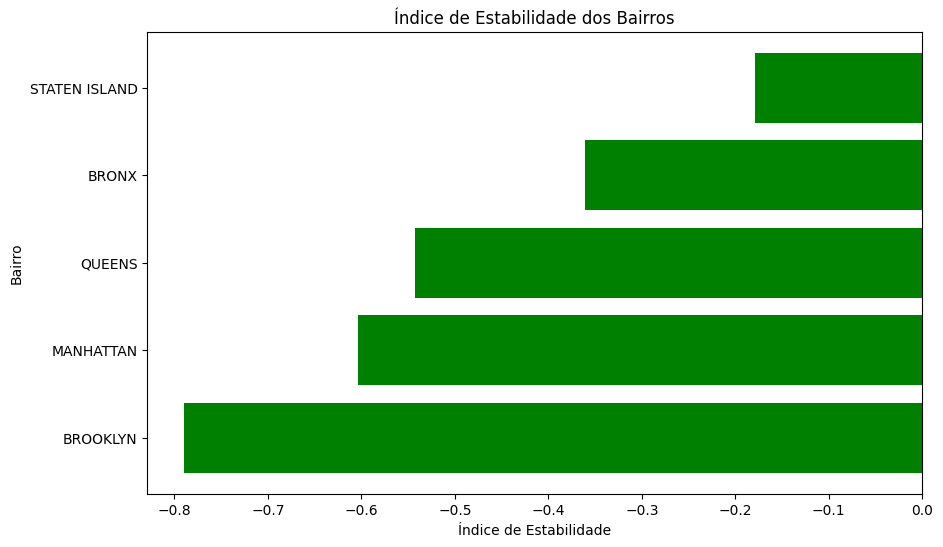

In [53]:
df_stability = df_mod.copy()

# Converter datas para datetime (se ainda não foram convertidas)
df_stability['created_date'] = pd.to_datetime(df_stability['created_date'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
df_stability['closed_date'] = pd.to_datetime(df_stability['closed_date'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')

# Criar coluna para o tempo de resolução em dias (caso não exista)
if 'resolution_time_days' not in df_stability.columns:
    df_stability['resolution_time_days'] = (df_stability['closed_date'] - df_stability['created_date']).dt.total_seconds() / (60 * 60 * 24)

# Agrupar métricas por bairro
stability_data = df_stability.groupby('borough').agg(
    total_complaints=('complaint_type', 'count'),
    avg_resolution_time=('resolution_time_days', 'mean'),
    closed_percentage=('status', lambda x: (x == 'Closed').mean() * 100),
    electric_issues=('complaint_type', lambda x: (x.str.contains('elec|power|wire|fuse', case=False, na=False)).sum()),
    water_issues=('complaint_type', lambda x: (x.str.contains('water|sewer|flooding|plumbing', case=False, na=False)).sum()),
    noise_issues=('complaint_type', lambda x: (x.str.contains('noise|construction', case=False, na=False)).sum()),
    health_issues=('complaint_type', lambda x: (x.str.contains('unsanitary|dirty|rodent', case=False, na=False)).sum())
).reset_index()

stability_data = stability_data.dropna()

scaler = MinMaxScaler()
normalized_values = scaler.fit_transform(stability_data.iloc[:, 1:])

# Pesos das métricas (ajustáveis)
weights = {
    'total_complaints': -0.3,  # Quantidade de ocorrencias - Quanto menor, melhor (peso negativo)
    'avg_resolution_time': -0.3,  # Tempo medio de solução das ocorrencias - Quanto menor, melhor
    'closed_percentage': 0.3,  # Txa de ocorrencias fechadas - Quanto maior, melhor
    # Problemas - Quanto menor, melhor
    'electric_issues': -0.2,
    'water_issues': -0.15,
    'noise_issues': -0.1,
    'health_issues': -0.05
}

stability_scores = (normalized_values * list(weights.values())).sum(axis=1)

stability_data['stability_index'] = stability_scores

# Ordenar bairros pelo Índice de Estabilidade (maior é melhor)
stability_data = stability_data.sort_values(by='stability_index', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(stability_data['borough'], stability_data['stability_index'], color='green')
plt.xlabel('Índice de Estabilidade')
plt.ylabel('Bairro')
plt.title('Índice de Estabilidade dos Bairros')
plt.gca().invert_yaxis()  # Inverter para mostrar o mais estável no topo
plt.show()

In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16602440 entries, 0 to 16602439
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Unique Key      int64  
 1   Created Date    object 
 2   Closed Date     object 
 3   Complaint Type  object 
 4   Descriptor      object 
 5   City            object 
 6   Status          object 
 7   Borough         object 
 8   Latitude        float64
 9   Longitude       float64
dtypes: float64(2), int64(1), object(7)
memory usage: 1.2+ GB


In [55]:
best_borough = stability_data.iloc[0]['borough']

df_best = df_stability[df_stability['borough'] == best_borough].copy()
df_best = df_best.dropna(subset=['latitude', 'longitude'])

# Agora o KMeans deve funcionar
n_clusters = 30  # ajuste conforme necessário
kmeans = KMeans(n_clusters=n_clusters, random_state=12)
df_best['cluster'] = kmeans.fit_predict(df_best[['latitude', 'longitude']])

if 'resolution_time_days' not in df_best.columns:
    df_best['resolution_time_days'] = (df_best['closed_date'] - df_best['created_date']).dt.total_seconds() / (60 * 60 * 24)

# --- 4. Agregação por Cluster (Região) ---
stability_clusters = df_best.groupby('cluster').agg(
    total_complaints=('complaint_type', 'count'),
    avg_resolution_time=('resolution_time_days', 'mean'),
    closed_percentage=('status', lambda x: (x == 'Closed').mean() * 100),
    electric_issues=('complaint_type', lambda x: x.str.contains('elec|power|wire|fuse', case=False, na=False).sum()),
    water_issues=('complaint_type', lambda x: x.str.contains('water|sewer|flooding|plumbing', case=False, na=False).sum()),
    noise_issues=('complaint_type', lambda x: x.str.contains('noise|construction', case=False, na=False).sum()),
    health_issues=('complaint_type', lambda x: x.str.contains('unsanitary|dirty|rodent', case=False, na=False).sum())
).reset_index()

stability_clusters = stability_clusters.dropna()

# Normalizar as métricas dos clusters
normalized_values_clusters = scaler.fit_transform(stability_clusters.iloc[:, 1:])

# Calcular o índice de estabilidade para cada cluster com os mesmos pesos
stability_scores_clusters = (normalized_values_clusters * np.array(list(weights.values()))).sum(axis=1)
stability_clusters['stability_index'] = stability_scores_clusters

# Ordena os clusters – maior índice indica maior estabilidade
stability_clusters = stability_clusters.sort_values(by='stability_index', ascending=False)

# Calcular o centro geográfico de cada cluster (média das coordenadas)
cluster_centers = df_best.groupby('cluster').agg(
    lat_mean=('latitude', 'mean'),
    lon_mean=('longitude', 'mean')
).reset_index()

# Mesclar os centros com os índices dos clusters
stability_clusters = pd.merge(stability_clusters, cluster_centers, on='cluster')

# --- 5. Montar o Heatmap ---
# Preparar os dados: cada linha deve conter [latitude, longitude, stability_index]
heat_data = stability_clusters[['lat_mean', 'lon_mean', 'stability_index']].values.tolist()

# Criar o mapa centrado no bairro
map_center = [df_best['latitude'].mean(), df_best['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=14)

# Adicionar o heatmap (quanto maior o stability_index, melhor a região)
HeatMap(heat_data, radius=30, blur=15, min_opacity=0.3, max_zoom=13).add_to(m)

# --- Adicionando marcadores coloridos de acordo com o índice de estabilidade ---
min_index = stability_clusters['stability_index'].min()
max_index = stability_clusters['stability_index'].max()
colormap = cm.LinearColormap(colors=['red', 'yellow', 'green'], vmin=min_index, vmax=max_index)
colormap.caption = 'Índice de Estabilidade'

for idx, row in stability_clusters.iterrows():
    folium.CircleMarker(
        location=[row['lat_mean'], row['lon_mean']],
        radius=8,
        color=colormap(row['stability_index']),
        fill=True,
        fill_color=colormap(row['stability_index']),
        fill_opacity=0.7,
        popup=f"Cluster {row['cluster']}<br>Estabilidade: {row['stability_index']:.2f}"
    ).add_to(m)

# Adicionar a legenda de cores ao mapa
colormap.add_to(m)

m
